In [1]:
! pip install numpy

In [2]:
# this is just a test submission just so we know that how our application of machine learning concepts is working
# we are not furnishing our final submission with this code as our own
# we are simply trying to famialize ourself with kaggle trough the submission of this arbitrary code inspired from kaggle


#import necessary packages
import pandas as pd, numpy as np, gc
from sklearn.model_selection import KFold, GroupKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [3]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

pre_train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(pre_train.shape))

Full train dataset shape is (26296946, 20)


In [4]:
# LOAD LABEL DATA
# Splits the session id and question into seperate columns. 
# Note, that a unique session id consists of all the questions corresponding to that 
# session, i.e. one session represents one user completing the game.
# We need to seperate this information to verify if the question is answered correctly 
# in later evaluations
trlabels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
trlabels['session'] = trlabels.session_id.apply(lambda x: int(x.split('_')[0]) )
trlabels['q'] = trlabels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( trlabels.shape )
trlabels.head()

(424116, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [5]:
# A distinction is made between categorical (string), numerical (floats or integers) and 
# event (string).
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

# https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [6]:
# Based on the different data defined above we engineer features that are grouped by, 
# and aggregated per unique session id and level group. Thus, resulting in a single row 
# for every session id containing the aggregated value of every feature.
# Note, that the questions within one session are grouped per level group,
# i.e. the 18 questions are distributed over 22 different levels, which makes up a 
# complete session.
def feature_engineer(train):   
    trains = []
    for c in CATS:
        #Define unique number of categorical data per level group within an unique session
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        trains.append(tmp)
    for c in NUMS:
        #Define the mean of the numerical data per level group within an unique session
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')        
        tmp.name = tmp.name + '_mean'
        trains.append(tmp)
    for c in NUMS:
        #Define the std of the numerical data per level group within an unique session
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')         
        tmp.name = tmp.name + '_std'
        trains.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        #Define the sum of the occurences of an event per level group within an unique session
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')         
        tmp.name = tmp.name + '_sum'
        trains.append(tmp)
    train = train.drop(EVENTS,axis=1)
        
    train = pd.concat(trains,axis=1)
    train = train.fillna(-1)
    train = train.reset_index()
    train = train.set_index('session_id')
    return train

In [7]:
# create the features per piece of training data and display the head
train = feature_engineer(pre_train)
train.head()

,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.0,7.701275,-71.413750,...,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,1.415594e+07
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.0,-130.347168,-162.004303,...,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,4.370523e+08
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.0,14.306062,-57.269321,...,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,1.057327e+08
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.0,-84.045959,-53.671082,...,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,1.357104e+07
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.1,-30.762283,-142.861893,...,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3.241011e+09


In [8]:
FEATURES = [c for c in train.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = train.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 30 features
We will train with 23562 users info


In [9]:
from sklearn.model_selection import GridSearchCV
gkf = GroupKFold(n_splits=2)

# Tip: try different kfold variations
# kf = KFold(n_splits=5) # example if you would like to try regular KFold

# predictions == out of fold (predictions) collected in a dataframe
# this means all predictions on test subset in each fold are collected
# in the predictions dataframe
predictions = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS) 
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=train, groups=train.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # Hyperparameters --> Tip: (automatic) tuning, e.g. GridSearchCV, RandomizedSearhCV,
    # or better yet: Bayesian Optimization

    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = train.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = trlabels.loc[trlabels.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = train.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = trlabels.loc[trlabels.q==t].set_index('session').loc[valid_users]
        
         # GRID SEARCH
        #param_grid = {"criterion": ["gini", "entropy"],
        #      "max_depth": np.arange(21),
         #     "n_estimators": [100, 1000]}

       # grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
       # grid.fit(train_x[FEATURES].astype('float32'), train_y['correct']);
        
        #models = grid.best_params_
        
        # TRAIN MODEL        
        clf =  RandomForestClassifier(criterion = "gini", max_depth = 4,
                                     n_estimators = 1000)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID predictions
        models[f'{grp}_{t}'] = clf
        predictions.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################

#########################
### Fold 2
#########################



In [10]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = predictions.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = trlabels.loc[trlabels.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [11]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (predictions.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

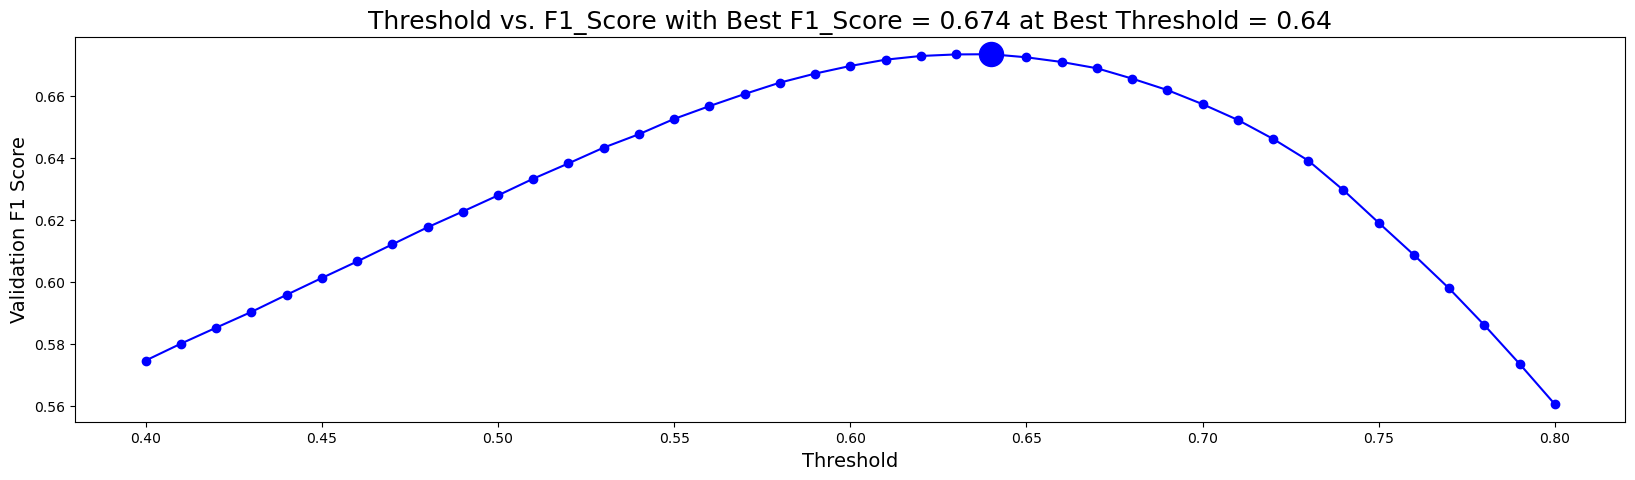

In [12]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [13]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (predictions[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =', m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (predictions.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =', m)

When using optimal threshold...
Q0: F1 = 0.5662617167457482
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.4829379622111523
Q3: F1 = 0.5637732667533084
Q4: F1 = 0.5101873033831125
Q5: F1 = 0.5937004079112538
Q6: F1 = 0.5685834275126962
Q7: F1 = 0.5222578869623671
Q8: F1 = 0.5812717236144959
Q9: F1 = 0.38285187254818587
Q10: F1 = 0.5862749515214962
Q11: F1 = 0.47576293523626395
Q12: F1 = 0.42025490871512233
Q13: F1 = 0.5913467444949032
Q14: F1 = 0.35832371031939747
Q15: F1 = 0.4502188827547471
Q16: F1 = 0.5331451212984747
Q17: F1 = 0.48734796893017995
==> Overall F1 = 0.6735564727657912


In [14]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del trlabels, train, predictions, true
_ = gc.collect()

In [15]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    
    # FEATURE ENGINEER TEST DATA
    train = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(train[FEATURES].astype('float32'))[0,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [16]:
train = pd.read_csv('submission.csv')
print( train.shape )
train.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090109393214576_q4,1
4,20090109393214576_q5,0
